# DATA PREPARATION
Install data and assign csv data file into pandas Dataframe

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

df = pd.read_csv("/kaggle/input/financial-transactions-dataset-for-fraud-detection/financial_fraud_detection_dataset.csv")

/kaggle/input/financial-transactions-dataset-for-fraud-detection/financial_fraud_detection_dataset.csv


In [2]:
import seaborn as sns
import polars as pl
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings("ignore") 

# DATA EXPLORATION (EDA)

In [3]:
#The first 5 data from the dataset
df.head()

,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash
0,T100000,2023-08-22T09:22:43.516168,ACC877572,ACC388389,343.78,withdrawal,utilities,Tokyo,mobile,False,NaN,NaN,-0.21,3,0.22,card,13.101.214.112,D8536477
1,T100001,2023-08-04T01:58:02.606711,ACC895667,ACC944962,419.65,withdrawal,online,Toronto,atm,False,NaN,NaN,-0.14,7,0.96,ACH,172.52.47.194,D2622631
2,T100002,2023-05-12T11:39:33.742963,ACC733052,ACC377370,2773.86,deposit,other,London,pos,False,NaN,NaN,-1.78,20,0.89,card,185.98.35.23,D4823498
3,T100003,2023-10-10T06:04:43.195112,ACC996865,ACC344098,1666.22,deposit,online,Sydney,pos,False,NaN,NaN,-0.60,6,0.37,wire_transfer,107.136.36.87,D9961380
4,T100004,2023-09-24T08:09:02.700162,ACC584714,ACC497887,24.43,transfer,utilities,Toronto,mobile,False,NaN,NaN,0.79,13,0.27,ACH,108.161.108.255,D7637601


## Data Overview
As we can see, the label for this dataset is attribute is_fraud with boolean label (True/False) to determine whether a transaction is fraudulent or legitimate 

In [4]:
#Display basic info of the dataset
print("Display Info: \n")
print(df.info())

Display Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 18 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   transaction_id               object 
 1   timestamp                    object 
 2   sender_account               object 
 3   receiver_account             object 
 4   amount                       float64
 5   transaction_type             object 
 6   merchant_category            object 
 7   location                     object 
 8   device_used                  object 
 9   is_fraud                     bool   
 10  fraud_type                   object 
 11  time_since_last_transaction  float64
 12  spending_deviation_score     float64
 13  velocity_score               int64  
 14  geo_anomaly_score            float64
 15  payment_channel              object 
 16  ip_address                   object 
 17  device_hash                  object 
dtypes: bool(1), float64(4), in

In [5]:
#Check for missing value
print(f"Shape of dataset: {df.shape}")
print(f"The amount of missing value: {df.isnull().sum()}")

Shape of dataset: (5000000, 18)
The amount of missing value: transaction_id                       0
timestamp                            0
sender_account                       0
receiver_account                     0
amount                               0
transaction_type                     0
merchant_category                    0
location                             0
device_used                          0
is_fraud                             0
fraud_type                     4820447
time_since_last_transaction     896513
spending_deviation_score             0
velocity_score                       0
geo_anomaly_score                    0
payment_channel                      0
ip_address                           0
device_hash                          0
dtype: int64


In [6]:
#Class distribution
fraud_trans_count = df["is_fraud"] == True
legit_trans_count = df["is_fraud"] == False
print(f"Fraud transactions: {fraud_trans_count.sum()} ({fraud_trans_count.sum()*100/df.shape[0]:.2f}%)")
print(f"Legitimate transactions: {legit_trans_count.sum()} ({legit_trans_count.sum()*100/df.shape[0]:.2f}%)")

Fraud transactions: 179553 (3.59%)
Legitimate transactions: 4820447 (96.41%)


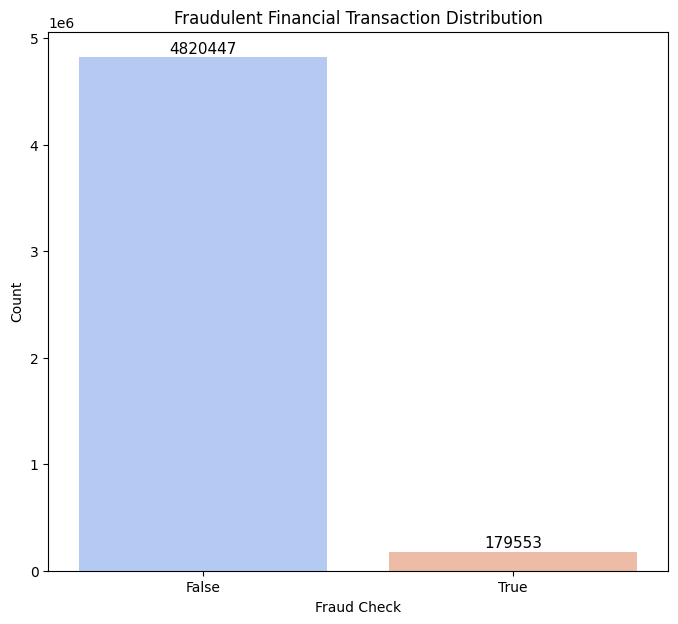

In [7]:
plt.figure(figsize=(8,7))
ax = sns.countplot(x='is_fraud',data=df,palette='coolwarm')
plt.title("Fraudulent Financial Transaction Distribution")
plt.xlabel("Fraud Check")
plt.ylabel("Count")

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                fontsize=11, color='black',
                xytext=(0, 6),textcoords='offset points')
plt.show()

In [8]:
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["hour"] = df["timestamp"].dt.hour
df["day"] = df["timestamp"].dt.day
df["day_of_week"] = df["timestamp"].dt.weekday
df["month"] = df["timestamp"].dt.month

## Convert Boolean labels into Numeric labels (0 and 1)
Models such as SVM, XGBoost,... prefer 0 and 1 more than True and False so I convert it

In [9]:
df["is_fraud"] = df["is_fraud"].astype(int)
df.head()

,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,...,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,hour,day,day_of_week,month
0,T100000,2023-08-22 09:22:43.516168,ACC877572,ACC388389,343.78,withdrawal,utilities,Tokyo,mobile,0,...,-0.21,3,0.22,card,13.101.214.112,D8536477,9.0,22.0,1.0,8.0
1,T100001,2023-08-04 01:58:02.606711,ACC895667,ACC944962,419.65,withdrawal,online,Toronto,atm,0,...,-0.14,7,0.96,ACH,172.52.47.194,D2622631,1.0,4.0,4.0,8.0
2,T100002,2023-05-12 11:39:33.742963,ACC733052,ACC377370,2773.86,deposit,other,London,pos,0,...,-1.78,20,0.89,card,185.98.35.23,D4823498,11.0,12.0,4.0,5.0
3,T100003,2023-10-10 06:04:43.195112,ACC996865,ACC344098,1666.22,deposit,online,Sydney,pos,0,...,-0.60,6,0.37,wire_transfer,107.136.36.87,D9961380,6.0,10.0,1.0,10.0
4,T100004,2023-09-24 08:09:02.700162,ACC584714,ACC497887,24.43,transfer,utilities,Toronto,mobile,0,...,0.79,13,0.27,ACH,108.161.108.255,D7637601,8.0,24.0,6.0,9.0


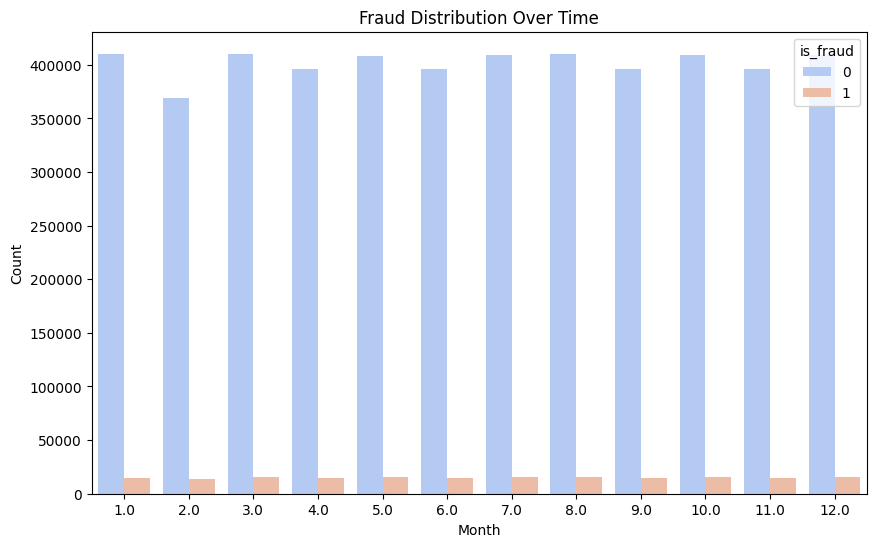

In [10]:
df_pandas = df.sample(n=df.shape[0],random_state = 19)
plt.figure(figsize=(10, 6))  # set figure size first
sns.countplot(x="month", data=df, palette="coolwarm", hue="is_fraud")
plt.title("Fraud Distribution Over Time")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

In [11]:
print(f"Statistic Describe: \n")
df.describe()

Statistic Describe: 



,timestamp,amount,is_fraud,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,hour,day,day_of_week,month
count,4999997,5.000000e+06,5.000000e+06,4.103487e+06,5.000000e+06,5.000000e+06,5.000000e+06,4.999997e+06,4.999997e+06,4.999997e+06,4.999997e+06
mean,2023-07-03 00:10:10.418650112,3.589343e+02,3.591060e-02,1.525799e+00,-3.881160e-04,1.050132e+01,5.000293e-01,1.149665e+01,1.572276e+01,2.999544e+00,6.527235e+00
min,2023-01-01 00:09:26.241974,1.000000e-02,0.000000e+00,-8.777814e+03,-5.260000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
25%,2023-04-02 17:32:38.758833920,2.657000e+01,0.000000e+00,-2.562376e+03,-6.800000e-01,5.000000e+00,2.500000e-01,5.000000e+00,8.000000e+00,1.000000e+00,4.000000e+00
50%,2023-07-03 01:27:16.670582016,1.386700e+02,0.000000e+00,8.442747e-01,0.000000e+00,1.100000e+01,5.000000e-01,1.100000e+01,1.600000e+01,3.000000e+00,7.000000e+00
75%,2023-10-02 05:43:06.393416960,5.038900e+02,0.000000e+00,2.568339e+03,6.700000e-01,1.600000e+01,7.500000e-01,1.700000e+01,2.300000e+01,5.000000e+00,1.000000e+01
max,2024-01-01 22:58:30.131850,3.520570e+03,1.000000e+00,8.757758e+03,5.020000e+00,2.000000e+01,1.000000e+00,2.300000e+01,3.100000e+01,6.000000e+00,1.200000e+01
std,NaN,4.699333e+02,1.860673e-01,3.576569e+03,1.000807e+00,5.766842e+00,2.886349e-01,6.921329e+00,8.796412e+00,2.003172e+00,3.447722e+00


## Statistical Summary
1. *Amount*: range from 0.01 to 3520.57, mean ≈358.9343, highly skewed (≈469.93). Amount of money in a transaction may affect the fraudulent rate of itself  
2. *spending_deviation_score*: range from -5.2 to 5.02, mean ≈0, std ≈1. Like normal distribution, useful for fraud detection  
3. *velocity_score*: range from 1 to 20, mean ≈10.5, std ≈5.77. High value may indicate rapid transactions – sign of fraud  
4. *geo_anomaly_score*: range from 0 to 1, mean ≈0.5, std ≈0.3. Likely a probability-like score, critical for fraud analysis.
5. *time_since_last_transaction*: range from -8777.814 to 8757.758, mean ≈1.53, std ≈3576.569. Highly skewed so it may not be effective for detecting fraud transaction

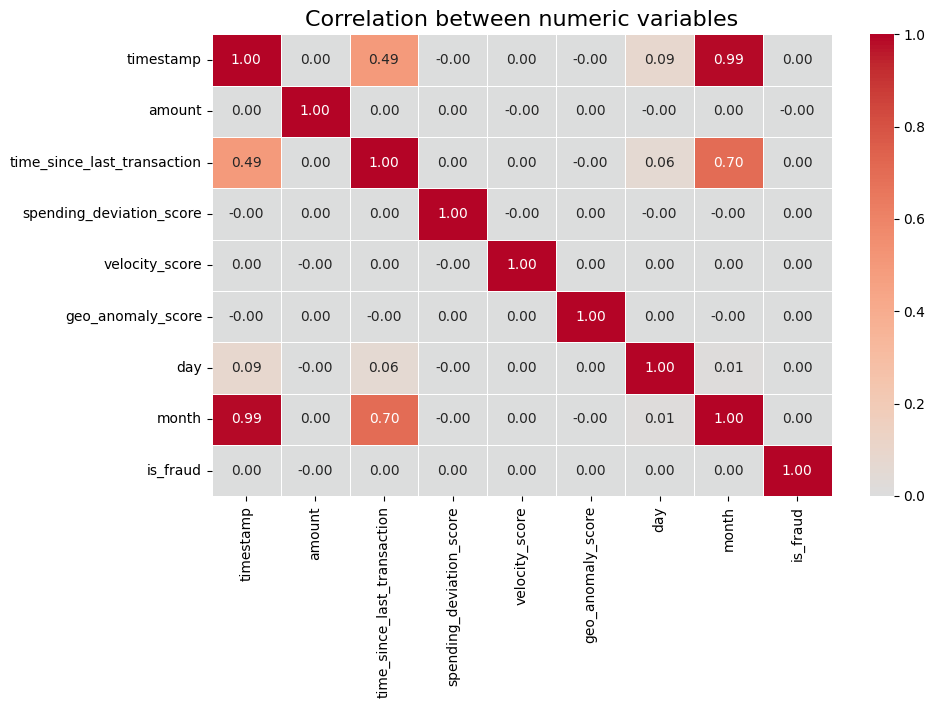

In [12]:
### Correlation for numeric variables
corr_df = df[["timestamp","amount","time_since_last_transaction","spending_deviation_score","velocity_score","geo_anomaly_score","day","month","is_fraud"]]
correlation_matrix = corr_df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix,annot=True,cmap='coolwarm',center=0,linewidths=0.5,cbar=True,fmt='.2f')
plt.title("Correlation between numeric variables",fontsize=16)
plt.show()

## Timestamp
Here we only consider month and day ofr fraud detection

In [13]:
### Month
fraud_by_month = (
    df.groupby("month")
    .agg(
        total_trans=("is_fraud", "count"),
        fraud_trans=("is_fraud", "sum")
    )
)
fraud_by_month["fraud_rate (%)"] = fraud_by_month["fraud_trans"]*100 / fraud_by_month["total_trans"]
fraud_by_month["fraud_rate (%)"] = fraud_by_month["fraud_rate (%)"].round(2)
fraud_by_month.sort_values("fraud_rate (%)",ascending=False).head(10)

,total_trans,fraud_trans,fraud_rate (%)
month,,,
7.0,424492,15395,3.63
12.0,424558,15376,3.62
9.0,411277,14855,3.61
10.0,424906,15331,3.61
2.0,382551,13777,3.60
4.0,411054,14761,3.59
6.0,410890,14759,3.59
3.0,425454,15247,3.58
11.0,411100,14730,3.58


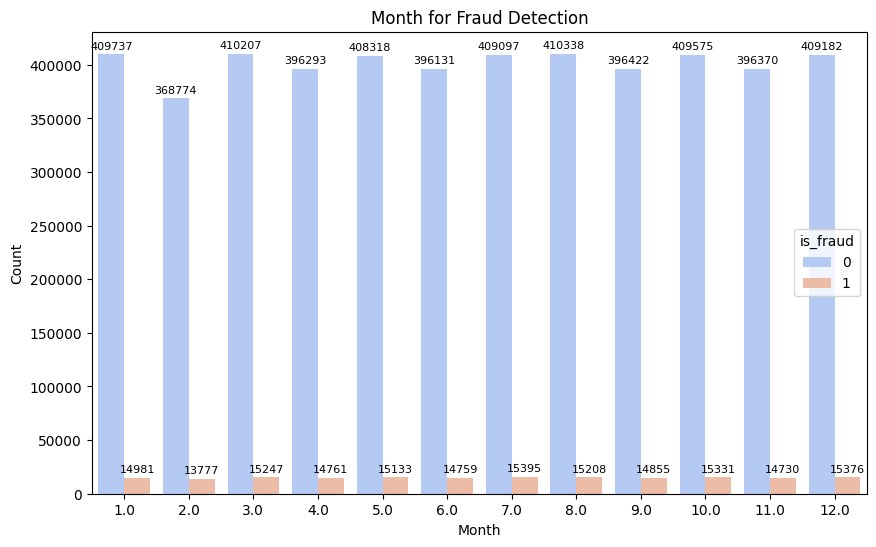

In [14]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='month',hue='is_fraud',data=df,palette='coolwarm')
plt.title('Month for Fraud Detection')
plt.legend(title='is_fraud',loc='center right')
plt.xlabel('Month')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                fontsize=8, color='black',
                xytext=(0, 6),textcoords='offset points')
plt.show()

In [15]:
### Day
fraud_by_day = (
    df.groupby("day")
    .agg(
        total_trans=("is_fraud", "count"),
        fraud_trans=("is_fraud", "sum")
    )
)
fraud_by_day["fraud_rate (%)"] = fraud_by_day["fraud_trans"]*100 / fraud_by_day["total_trans"]
fraud_by_day["fraud_rate (%)"] = fraud_by_day["fraud_rate (%)"].round(2)
fraud_by_day.sort_values("fraud_rate (%)",ascending=False).head(100)

,total_trans,fraud_trans,fraud_rate (%)
day,,,
29.0,150622,5520,3.66
9.0,164309,6021,3.66
23.0,164134,6010,3.66
8.0,164299,5982,3.64
21.0,165429,6023,3.64
28.0,164428,5975,3.63
26.0,164901,5983,3.63
7.0,164035,5930,3.62
11.0,163454,5917,3.62


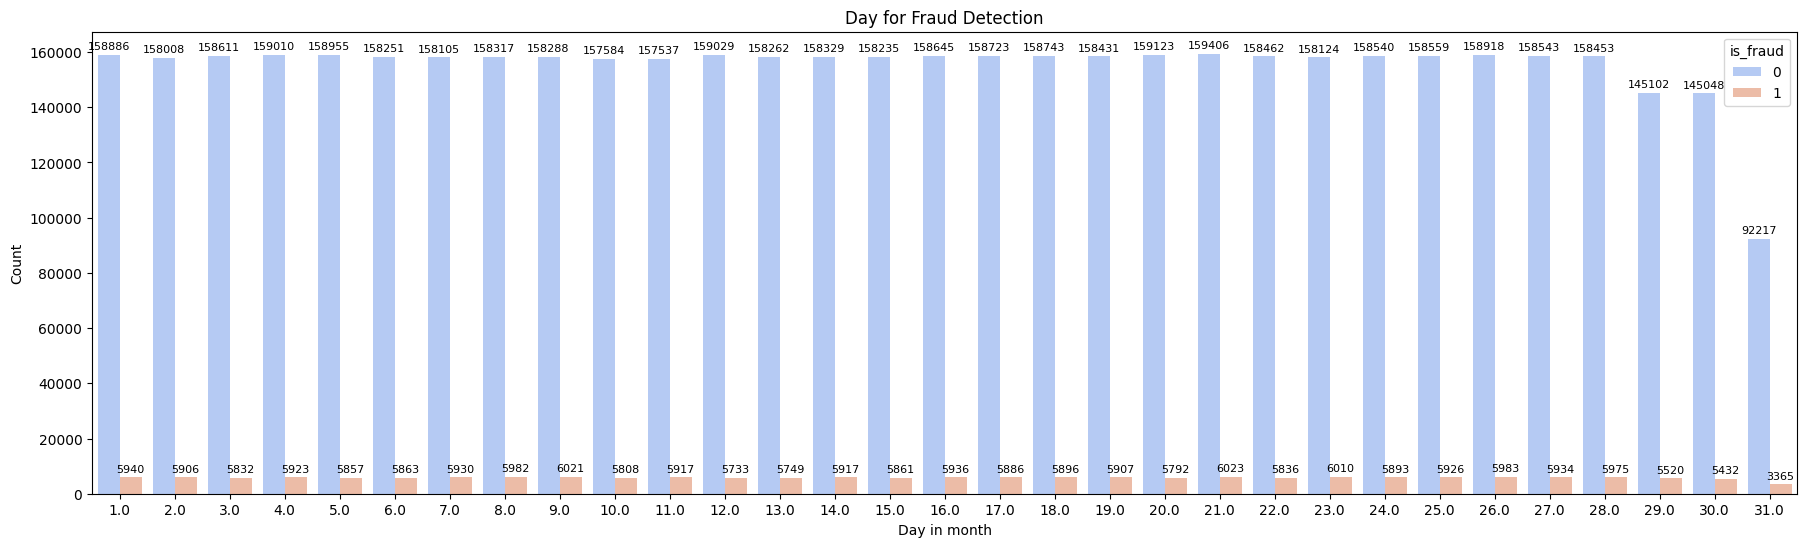

In [16]:
plt.figure(figsize=(22,6))
ax = sns.countplot(x='day',hue='is_fraud',data=df,palette='coolwarm')
plt.title('Day for Fraud Detection')
# plt.legend(title='is_fraud',loc='center right')
plt.xlabel('Day in month')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                fontsize=8, color='black',
                xytext=(0, 6),textcoords='offset points')
plt.show()

## Sender/Receiver Account

In [17]:
# Sender/Receiver
print(f"Number of senders: {np.unique(df['sender_account']).size}")
print(f"Number of receivers: {np.unique(df['receiver_account']).size}")

Number of senders: 896513
Number of receivers: 896639


In [18]:
# Top 10 most active sender in the dataset
df.groupby("sender_account").size().reset_index(name="count").sort_values("count", ascending=False).head(10)

,sender_account,count
880495,ACC983922,20
759735,ACC862649,19
828457,ACC931649,19
306713,ACC407908,19
752113,ACC854997,19
38337,ACC138486,19
295526,ACC396669,18
403585,ACC505160,18
281565,ACC382656,18
721943,ACC824720,18


In [19]:
# Top 10 most active receiver in the dataset
df.groupby("receiver_account").size().reset_index(name="count").sort_values("count",ascending=False).head(10)

,receiver_account,count
299127,ACC400278,23
702040,ACC804655,20
889446,ACC992780,19
350954,ACC452312,19
617176,ACC719493,19
851661,ACC954845,18
851278,ACC954459,18
814386,ACC917408,18
205355,ACC306162,18
641321,ACC743715,18


In [20]:
# Calculate the rate that related to each account
fraud_by_sender = (
    df.groupby("sender_account")
    .agg(
        total_trans=("is_fraud", "count"),
        fraud_trans=("is_fraud", "sum")
    )
)
fraud_by_sender["fraud_rate (%)"] = fraud_by_sender["fraud_trans"]*100 / fraud_by_sender["total_trans"]
fraud_by_sender["fraud_rate (%)"] = fraud_by_sender["fraud_rate (%)"].round(2)
fraud_by_sender.sort_values("fraud_rate (%)",ascending=False).head(10)

,total_trans,fraud_trans,fraud_rate (%)
sender_account,,,
ACC802400,4,3,75.0
ACC741428,4,3,75.0
ACC340345,4,3,75.0
ACC774428,4,3,75.0
ACC952479,4,3,75.0
ACC111101,4,3,75.0
ACC921829,4,3,75.0
ACC690487,4,3,75.0
ACC578240,4,3,75.0


In [21]:
fraud_by_receiver = (
    df.groupby("receiver_account").agg(
        total_trans=('is_fraud','count'),
        fraud_trans=('is_fraud','sum')
    )
)
fraud_by_receiver['fraud_rate (%)'] = fraud_by_receiver['fraud_trans']*100/fraud_by_receiver['total_trans']
fraud_by_receiver['fraud_rate (%)'] = fraud_by_receiver['fraud_rate (%)'].round(2)
fraud_by_receiver.sort_values("fraud_rate (%)",ascending=False).head(10)

,total_trans,fraud_trans,fraud_rate (%)
receiver_account,,,
ACC239502,2,2,100.0
ACC988121,1,1,100.0
ACC119203,1,1,100.0
ACC392984,1,1,100.0
ACC630181,1,1,100.0
ACC531033,1,1,100.0
ACC157216,1,1,100.0
ACC878661,1,1,100.0
ACC859588,1,1,100.0


In [22]:
#### Top 10 most active pair of accounts in the dataset

df.groupby(["sender_account","receiver_account"]).agg(
    total_trans=('is_fraud','count'),
    fraud_trans=('is_fraud','sum')
).sort_values("fraud_trans",ascending=False).head(10)

total_trans  fraud_trans
sender_account receiver_account                          
ACC664847      ACC363363                   1            1
ACC852738      ACC111771                   1            1
ACC905233      ACC701364                   1            1
ACC467144      ACC458115                   1            1
ACC803782      ACC138325                   1            1
ACC303747      ACC741070                   1            1
               ACC412117                   1            1
ACC905236      ACC802942                   1            1
ACC905237      ACC647925                   1            1
ACC252713      ACC115040                   1            1

## Amount

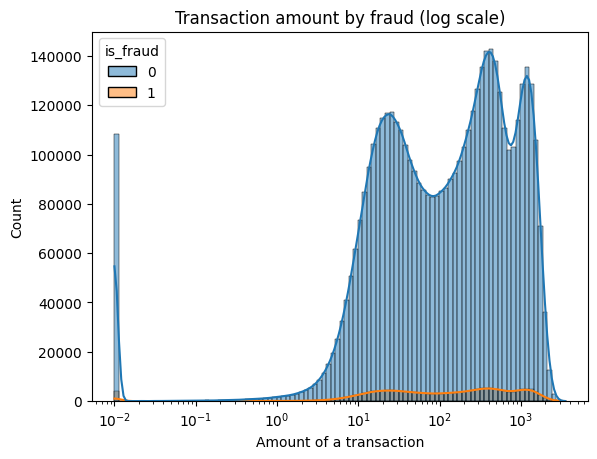

In [23]:
sns.histplot(df,x='amount',hue='is_fraud',bins=100,kde=True,log_scale=True)
plt.xlabel('Amount of a transaction')
plt.title("Transaction amount by fraud (log scale)")
plt.show()

## Merchant Category

In [24]:
fraud_by_mc = (df.groupby('merchant_category').agg(
    total_trans=('is_fraud','count'),
    fraud_trans=('is_fraud','sum')
))
fraud_by_mc['fraud_rate (%)'] = fraud_by_mc['fraud_trans']*100/fraud_by_mc['total_trans']
fraud_by_mc['fraud_rate (%)']= fraud_by_mc['fraud_rate (%)'].round(2)
fraud_by_mc.sort_values("fraud_rate (%)",ascending=False).head(10)

,total_trans,fraud_trans,fraud_rate (%)
merchant_category,,,
entertainment,625332,22573,3.61
other,624589,22556,3.61
grocery,624954,22516,3.60
travel,625656,22503,3.60
online,623581,22324,3.58
restaurant,625483,22367,3.58
retail,626319,22453,3.58
utilities,624086,22261,3.57


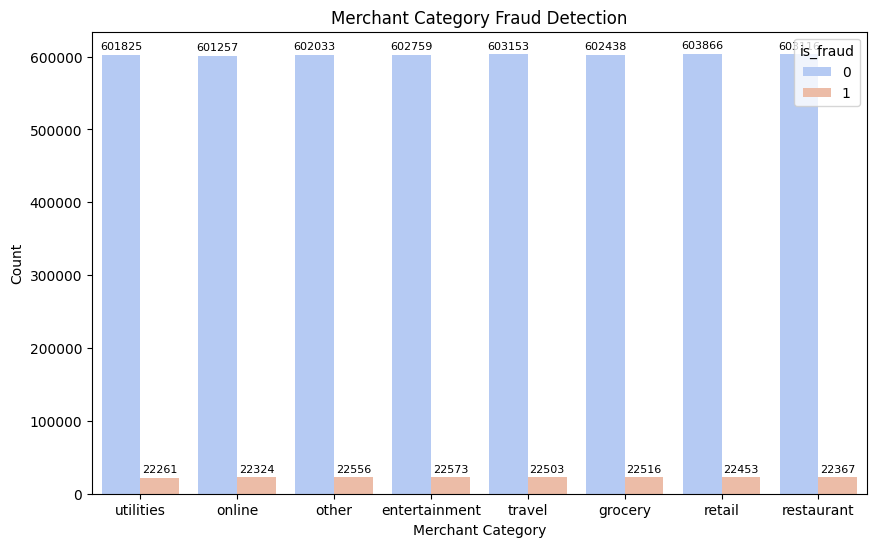

In [25]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='merchant_category',hue='is_fraud',data=df,palette='coolwarm')
plt.title('Merchant Category Fraud Detection')
plt.xlabel('Merchant Category')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                fontsize=8, color='black',
                xytext=(0, 6),textcoords='offset points')
plt.show()

## Transaction Type

In [26]:
df.groupby("transaction_type").size().reset_index(name="Count").sort_values("Count",ascending=False).head(10)

,transaction_type,Count
0,deposit,1250593
1,payment,1250438
2,transfer,1250334
3,withdrawal,1248635


In [27]:
#Lets see what fraud most use transaction type
fraud_by_tp = (df.groupby('transaction_type').agg(
    total_trans=('is_fraud','count'),
    fraud_trans=('is_fraud','sum')
))
fraud_by_tp['fraud_rate (%)'] = fraud_by_tp['fraud_trans']*100/fraud_by_tp['total_trans']
fraud_by_tp['fraud_rate (%)']= fraud_by_tp['fraud_rate (%)'].round(2)
fraud_by_tp.sort_values("fraud_rate (%)",ascending=False).head()

,total_trans,fraud_trans,fraud_rate (%)
transaction_type,,,
transfer,1250334,45328,3.63
withdrawal,1248635,44874,3.59
deposit,1250593,44786,3.58
payment,1250438,44565,3.56


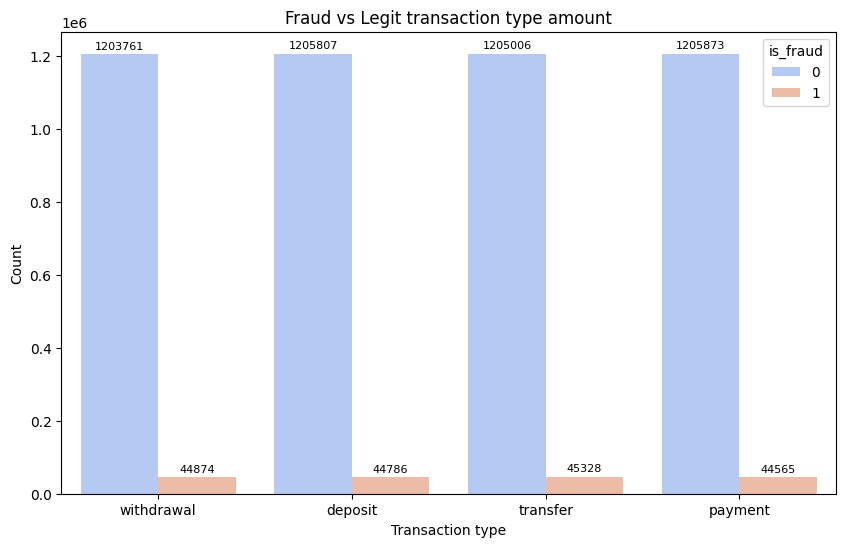

In [28]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='transaction_type',hue='is_fraud',data=df,palette='coolwarm')
plt.title('Fraud vs Legit transaction type amount')
plt.xlabel('Transaction type')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                fontsize=8, color='black',
                xytext=(0, 6),textcoords='offset points')
plt.show()

## Spending Deviation Score

In [29]:

fraud_by_sds = (df.groupby("spending_deviation_score").agg(
    total_trans=('is_fraud','count'),
    fraud_trans=('is_fraud','sum')
).sort_values('fraud_trans',ascending=False))
fraud_by_sds['fraud_rate (%)'] = fraud_by_sds['fraud_trans']*100/fraud_by_sds['total_trans']
fraud_by_sds['fraud_rate (%)'] = fraud_by_sds['fraud_rate (%)'].round(2)
fraud_by_sds.head(10)

,total_trans,fraud_trans,fraud_rate (%)
spending_deviation_score,,,
0.15,19779,762,3.85
0.07,19742,759,3.84
0.02,19802,757,3.82
-0.00,20087,756,3.76
-0.11,19903,750,3.77
0.17,19665,747,3.80
-0.23,19558,743,3.80
-0.07,20078,741,3.69
0.13,19571,740,3.78


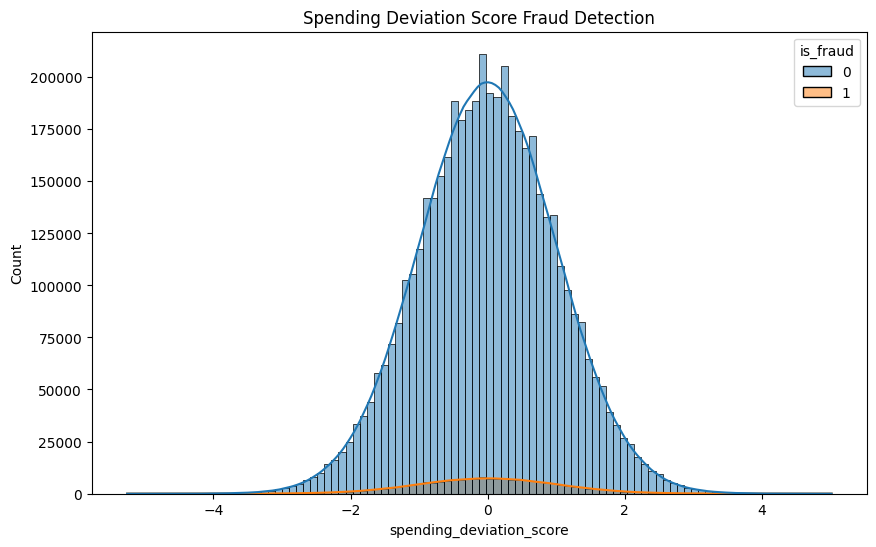

In [30]:
plt.figure(figsize=(10,6))
sns.histplot(data=df,x='spending_deviation_score',hue='is_fraud',bins=100,kde=True)
plt.title("Spending Deviation Score Fraud Detection")
plt.show()

## Velocity Score

In [31]:
fraud_by_vs = (df.groupby("velocity_score").agg(
    total_trans=('is_fraud','count'),
    fraud_trans=('is_fraud','sum')
))
fraud_by_vs['fraud_rate (%)'] = fraud_by_vs['fraud_trans']*100/fraud_by_vs['total_trans']
fraud_by_vs['fraud_rate (%)'] = fraud_by_vs['fraud_rate (%)'].round(2)
fraud_by_vs.sort_values('fraud_rate (%)',ascending=False).head(10)

,total_trans,fraud_trans,fraud_rate (%)
velocity_score,,,
17,250353,9102,3.64
18,250777,9096,3.63
5,249956,9083,3.63
6,249818,9078,3.63
8,249065,9053,3.63
20,250050,9030,3.61
12,249695,9018,3.61
19,249834,9030,3.61
11,249904,8992,3.60


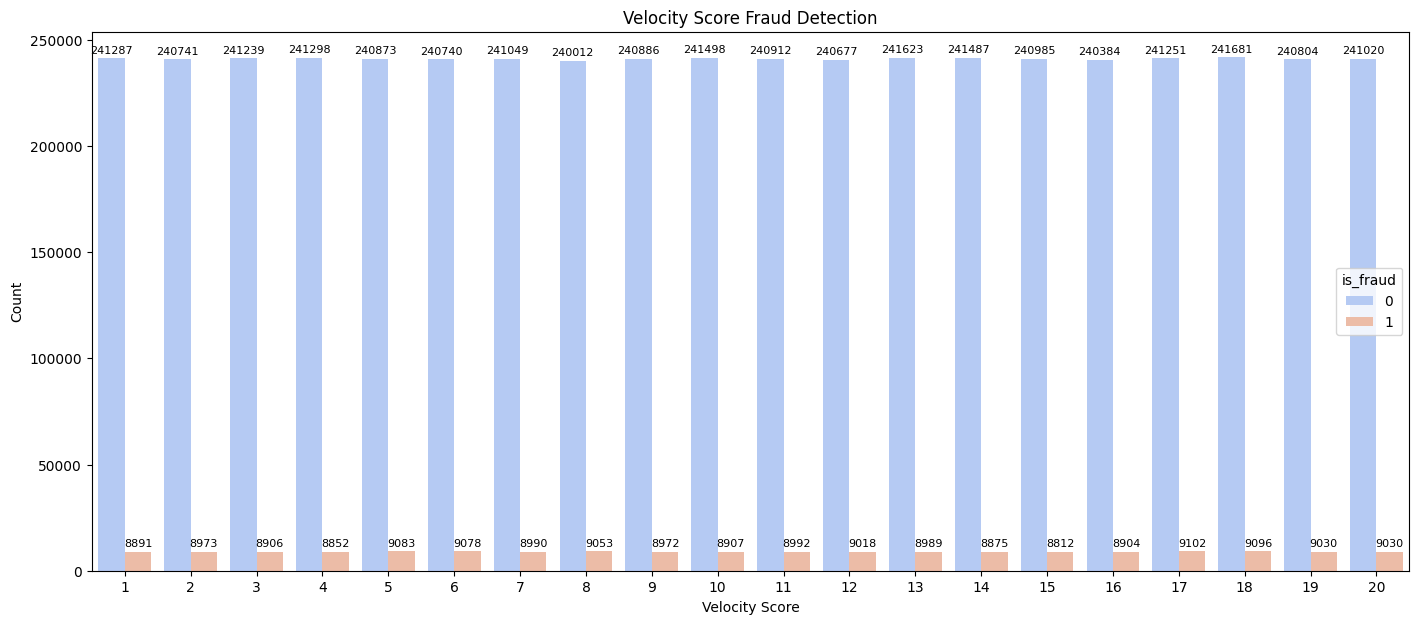

In [32]:
plt.figure(figsize=(17,7))
ax = sns.countplot(data=df,x='velocity_score',hue='is_fraud',palette='coolwarm')
ax.legend(title="is_fraud",loc='center right')
plt.title("Velocity Score Fraud Detection")
plt.xlabel("Velocity Score")
plt.ylabel("Count")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                fontsize=8, color='black',
                xytext=(0, 6),textcoords='offset points')
plt.show()


## Geo Anomaly Score

In [33]:
fraud_by_gas = (df.groupby("geo_anomaly_score").agg(
    total_trans=('is_fraud','count'),
    fraud_trans=('is_fraud','sum')
))
fraud_by_gas['fraud_rate (%)'] = fraud_by_gas['fraud_trans']*100/fraud_by_gas['total_trans']
fraud_by_gas['fraud_rate (%)'] = fraud_by_gas['fraud_rate (%)'].round(2)
fraud_by_gas.sort_values('fraud_rate (%)').head(10)

,total_trans,fraud_trans,fraud_rate (%)
geo_anomaly_score,,,
0.04,50116,1680,3.35
0.68,49850,1692,3.39
0.15,49600,1697,3.42
0.83,49585,1694,3.42
0.67,50384,1734,3.44
0.18,49876,1721,3.45
0.47,49951,1731,3.47
0.43,50018,1738,3.47
0.08,50295,1749,3.48


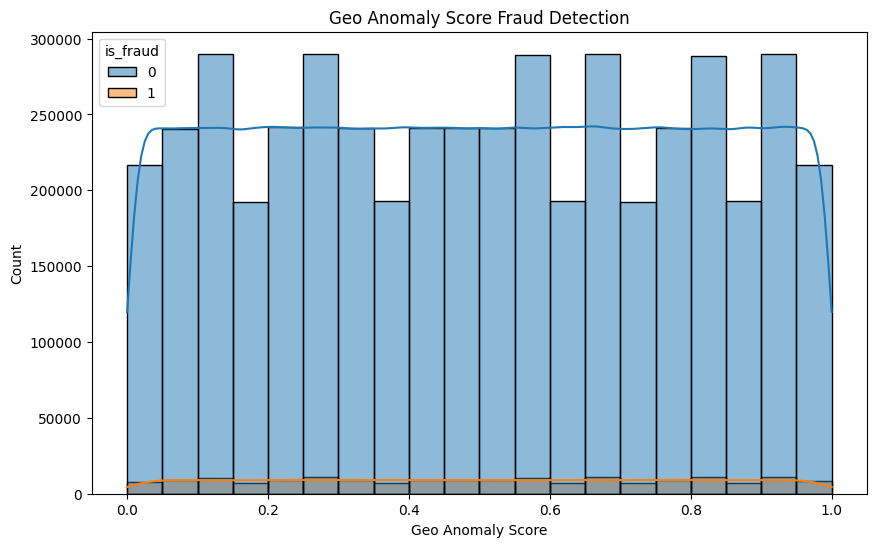

In [34]:
plt.figure(figsize=(10,6))
sns.histplot(data=df,x='geo_anomaly_score',bins=20,hue='is_fraud',kde=True)
plt.title("Geo Anomaly Score Fraud Detection")
plt.xlabel("Geo Anomaly Score")
plt.ylabel("Count")
plt.show()

## IP Address

In [35]:
fraud_by_ip = (df.groupby("ip_address").agg(
    total_trans=('is_fraud','count'),
    fraud_trans=('is_fraud','sum')
))
fraud_by_ip['fraud_rate (%)'] = fraud_by_ip['fraud_trans']*100/fraud_by_ip['total_trans']
fraud_by_ip['fraud_rate (%)'] = fraud_by_ip['fraud_rate (%)'].round(2)
fraud_by_ip.sort_values('fraud_rate (%)',ascending=False).head(10)

,total_trans,fraud_trans,fraud_rate (%)
ip_address,,,
5.86.19.78,1,1,100.0
171.154.195.161,1,1,100.0
194.252.110.138,1,1,100.0
103.235.138.44,1,1,100.0
35.45.58.149,1,1,100.0
192.20.163.22,1,1,100.0
145.47.73.216,1,1,100.0
45.174.227.141,1,1,100.0
248.25.209.19,1,1,100.0


## Location

In [36]:
fraud_by_loc = (df.groupby("location").agg(
    total_trans=('is_fraud','count'),
    fraud_trans=('is_fraud','sum')
))
fraud_by_loc['fraud_rate (%)'] = fraud_by_loc['fraud_trans']*100/fraud_by_loc['total_trans']
fraud_by_loc['fraud_rate (%)'] = fraud_by_loc['fraud_rate (%)'].round(2)
fraud_by_loc.sort_values('fraud_rate (%)',ascending=False).head(10)

,total_trans,fraud_trans,fraud_rate (%)
location,,,
London,624256,22478,3.60
Toronto,624349,22501,3.60
Berlin,625289,22435,3.59
New York,625354,22460,3.59
Singapore,625313,22461,3.59
Sydney,625125,22458,3.59
Dubai,624320,22340,3.58
Tokyo,625994,22420,3.58


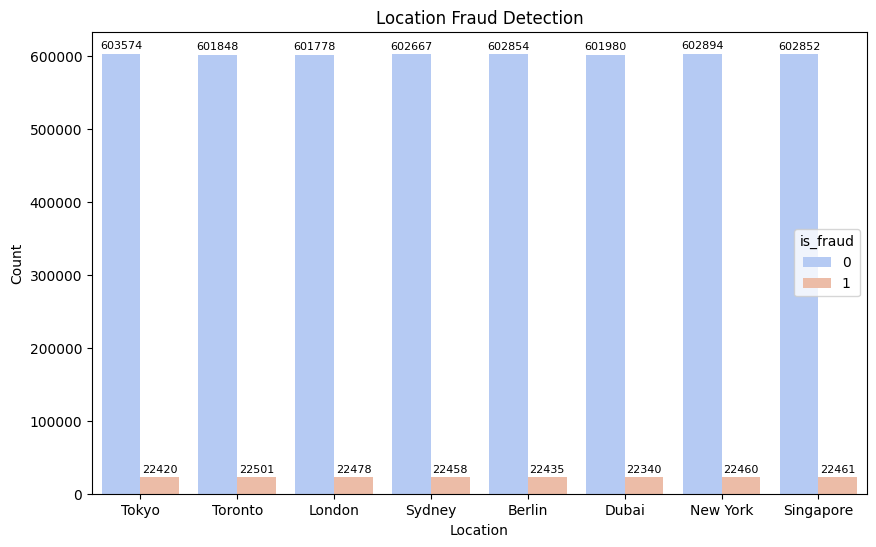

In [37]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='location',hue='is_fraud',data=df,palette='coolwarm')
plt.title('Location Fraud Detection')
plt.xlabel('Location')
plt.ylabel('Count')
plt.legend(title='is_fraud',loc='center right')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                fontsize=8, color='black',
                xytext=(0, 6),textcoords='offset points')
plt.show()

## Payment Channel

In [38]:
fraud_by_pc = (df.groupby("payment_channel").agg(
    total_trans=('is_fraud','count'),
    fraud_trans=('is_fraud','sum')
))
fraud_by_pc['fraud_rate (%)'] = fraud_by_pc['fraud_trans']*100/fraud_by_pc['total_trans']
fraud_by_pc['fraud_rate (%)'] = fraud_by_pc['fraud_rate (%)'].round(2)
fraud_by_pc.sort_values('fraud_rate (%)',ascending=False).head(10)

,total_trans,fraud_trans,fraud_rate (%)
payment_channel,,,
wire_transfer,1251219,45034,3.60
UPI,1248847,44896,3.59
card,1249693,44885,3.59
ACH,1250241,44738,3.58


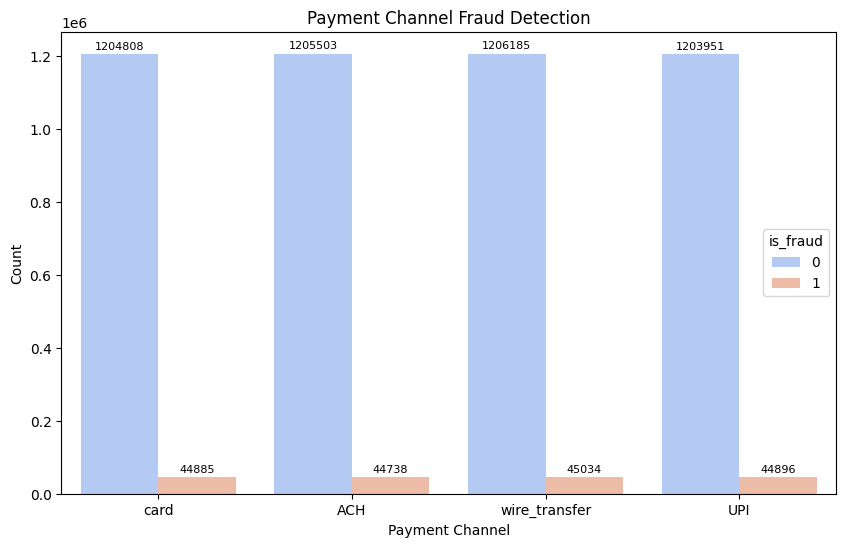

In [39]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='payment_channel',hue='is_fraud',data=df,palette='coolwarm')
plt.title('Payment Channel Fraud Detection')
plt.xlabel('Payment Channel')
plt.ylabel('Count')
plt.legend(title='is_fraud',loc='center right')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                fontsize=8, color='black',
                xytext=(0, 6),textcoords='offset points')
plt.show()

## Device Hash

In [40]:
fraud_by_dh = (df.groupby("device_hash").agg(
    total_trans=('is_fraud','count'),
    fraud_trans=('is_fraud','sum')
))
fraud_by_dh['fraud_rate (%)'] = fraud_by_dh['fraud_trans']*100/fraud_by_dh['total_trans']
fraud_by_dh['fraud_rate (%)'] = fraud_by_dh['fraud_rate (%)'].round(2)
fraud_by_dh.sort_values('fraud_rate (%)',ascending=False).head(10)

,total_trans,fraud_trans,fraud_rate (%)
device_hash,,,
D1660976,1,1,100.0
D5343450,1,1,100.0
D3172152,1,1,100.0
D2121799,1,1,100.0
D9163516,1,1,100.0
D9381589,1,1,100.0
D9724263,1,1,100.0
D3629679,1,1,100.0
D5857973,1,1,100.0


# DATA PREPROCESSING
1. Data Cleaning/Preprocessing
   Method:
    - SimpleImpute (Handle missing value)
    - LabelEncoder (Handle Categorical Features)
    - Scaler (Hanedle Numeric Features)
2. Feature Engineering
3. Feature Selection/Dimension Reduction

In [41]:
## Library for Data Processing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [42]:
#1 Handle Missing values
### time_since_last_spend
imputer = SimpleImputer(strategy="mean")
df[df.select_dtypes(include=np.number).columns] = imputer.fit_transform(
    df.select_dtypes(include=np.number)
)
df.head()

,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,...,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,hour,day,day_of_week,month
0,T100000,2023-08-22 09:22:43.516168,ACC877572,ACC388389,343.78,withdrawal,utilities,Tokyo,mobile,0.0,...,-0.21,3.0,0.22,card,13.101.214.112,D8536477,9.0,22.0,1.0,8.0
1,T100001,2023-08-04 01:58:02.606711,ACC895667,ACC944962,419.65,withdrawal,online,Toronto,atm,0.0,...,-0.14,7.0,0.96,ACH,172.52.47.194,D2622631,1.0,4.0,4.0,8.0
2,T100002,2023-05-12 11:39:33.742963,ACC733052,ACC377370,2773.86,deposit,other,London,pos,0.0,...,-1.78,20.0,0.89,card,185.98.35.23,D4823498,11.0,12.0,4.0,5.0
3,T100003,2023-10-10 06:04:43.195112,ACC996865,ACC344098,1666.22,deposit,online,Sydney,pos,0.0,...,-0.60,6.0,0.37,wire_transfer,107.136.36.87,D9961380,6.0,10.0,1.0,10.0
4,T100004,2023-09-24 08:09:02.700162,ACC584714,ACC497887,24.43,transfer,utilities,Toronto,mobile,0.0,...,0.79,13.0,0.27,ACH,108.161.108.255,D7637601,8.0,24.0,6.0,9.0


In [43]:
### fraud_type
## Because fraud type does not mean anything else than is_fraud so we drop it
df = df.drop(columns=["fraud_type"])
df.head()

,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,...,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,hour,day,day_of_week,month
0,T100000,2023-08-22 09:22:43.516168,ACC877572,ACC388389,343.78,withdrawal,utilities,Tokyo,mobile,0.0,...,-0.21,3.0,0.22,card,13.101.214.112,D8536477,9.0,22.0,1.0,8.0
1,T100001,2023-08-04 01:58:02.606711,ACC895667,ACC944962,419.65,withdrawal,online,Toronto,atm,0.0,...,-0.14,7.0,0.96,ACH,172.52.47.194,D2622631,1.0,4.0,4.0,8.0
2,T100002,2023-05-12 11:39:33.742963,ACC733052,ACC377370,2773.86,deposit,other,London,pos,0.0,...,-1.78,20.0,0.89,card,185.98.35.23,D4823498,11.0,12.0,4.0,5.0
3,T100003,2023-10-10 06:04:43.195112,ACC996865,ACC344098,1666.22,deposit,online,Sydney,pos,0.0,...,-0.60,6.0,0.37,wire_transfer,107.136.36.87,D9961380,6.0,10.0,1.0,10.0
4,T100004,2023-09-24 08:09:02.700162,ACC584714,ACC497887,24.43,transfer,utilities,Toronto,mobile,0.0,...,0.79,13.0,0.27,ACH,108.161.108.255,D7637601,8.0,24.0,6.0,9.0


In [44]:
#2 Handle categorical features
for col in df.select_dtypes(include=["object","category"]).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
df.head()

,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,...,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,hour,day,day_of_week,month
0,0,2023-08-22 09:22:43.516168,774605,287290,343.78,3,7,6,1,0.0,...,-0.21,3.0,0.22,2,684409,3212380,9.0,22.0,1.0,8.0
1,11,2023-08-04 01:58:02.606711,792638,841820,419.65,3,2,7,0,0.0,...,-0.14,7.0,0.96,0,1616508,691787,1.0,4.0,4.0,8.0
2,22,2023-05-12 11:39:33.742963,630602,276316,2773.86,0,3,2,2,0.0,...,-1.78,20.0,0.89,2,1893332,1629699,11.0,12.0,4.0,5.0
3,33,2023-10-10 06:04:43.195112,893387,243162,1666.22,0,2,5,2,0.0,...,-0.60,6.0,0.37,3,198681,3819233,6.0,10.0,1.0,10.0
4,44,2023-09-24 08:09:02.700162,482844,396342,24.43,2,7,7,1,0.0,...,0.79,13.0,0.27,0,220250,2829128,8.0,24.0,6.0,9.0


# FEATURE ENGINEERING
1. Scaler (scaling data)
2. Data creation

In [45]:
## Amount features
df["amount_per_velocity"] = df["amount"]/(df["velocity_score"] + 1)
df["amount_log"] = np.log1p(df["amount"])
df["amount_to_avg_ratio"] = df["amount"]/df.groupby("sender_account")["amount"].transform("mean")
## Frequency features
df["transaction_per_day"] = df.groupby(["sender_account","day"])["amount"].transform("count")
df["transaction_gap"] = (df.groupby("sender_account")["timestamp"].diff().dt.total_seconds().fillna(0))
## Risk features
df["is_night_transaction"] = df["hour"].between(18,24).astype(int)
df["is_weekend"] = df["day_of_week"].isin([6,8]).astype(int)
df["is_self_transfer"] = (df["sender_account"] == df["receiver_account"]).astype(int)
## Network features
df["sender_degree"] = df.groupby("sender_account")["receiver_account"].transform("nunique")
df["receiver_degree"] = df.groupby("receiver_account")["sender_account"].transform("nunique")
df["sender_total_transaction"] = df.groupby("sender_account")["amount"].transform("count")
df["receiver_total_transaction"] = df.groupby("receiver_account")["amount"].transform("count")
## Aggregation features
df["sender_avg_amount"] = df.groupby("sender_account")["amount"].transform("mean")
df["sender_std_amount"] = df.groupby("sender_account")["amount"].transform("std").fillna(0)
## Fraud features
df["sender_fraud_transaction"] = df.groupby("sender_account")["is_fraud"].transform("sum")
df["receiver_fraud_transaction"] = df.groupby("receiver_account")["is_fraud"].transform("sum")

df["sender_fraud_percentage (%)"] = (df["sender_fraud_transaction"]*100/df["sender_total_transaction"]).round(2)
df["receiver_fraud_percentage (%)"] = (df["receiver_fraud_transaction"]*100/df["receiver_total_transaction"]).round(2)

df[["sender_fraud_percentage (%)", "receiver_fraud_percentage (%)"]] = df[["sender_fraud_percentage (%)", "receiver_fraud_percentage (%)"]].fillna(0)
## Others
df["deviation_squared"] = df["spending_deviation_score"] ** 2
df.head(10)

,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,...,receiver_degree,sender_total_transaction,receiver_total_transaction,sender_avg_amount,sender_std_amount,sender_fraud_transaction,receiver_fraud_transaction,sender_fraud_percentage (%),receiver_fraud_percentage (%),deviation_squared
0,0,2023-08-22 09:22:43.516168,774605,287290,343.78,3,7,6,1,0.0,...,6,5,6,139.254000,134.787138,0.0,1.0,0.00,16.67,0.0441
1,11,2023-08-04 01:58:02.606711,792638,841820,419.65,3,2,7,0,0.0,...,5,6,5,168.301667,164.970814,0.0,0.0,0.00,0.00,0.0196
2,22,2023-05-12 11:39:33.742963,630602,276316,2773.86,0,3,2,2,0.0,...,4,7,4,597.892857,990.233513,0.0,0.0,0.00,0.00,3.1684
3,33,2023-10-10 06:04:43.195112,893387,243162,1666.22,0,2,5,2,0.0,...,5,4,5,694.362500,807.082916,0.0,0.0,0.00,0.00,0.3600
4,44,2023-09-24 08:09:02.700162,482844,396342,24.43,2,7,7,1,0.0,...,6,4,6,368.550000,652.920482,0.0,0.0,0.00,0.00,0.6241
5,55,2023-11-20 17:49:27.940971,479284,149224,58.77,2,0,0,0,0.0,...,3,4,3,214.785000,189.468315,0.0,0.0,0.00,0.00,2.6569
6,66,2023-11-11 11:15:41.359248,655396,167088,59.51,1,6,1,2,0.0,...,6,8,6,378.933750,522.199782,0.0,0.0,0.00,0.00,6.8644
7,77,2023-06-09 06:32:36.945101,3389,754378,29.79,2,0,2,0,0.0,...,8,7,8,510.358571,463.430235,1.0,0.0,14.29,0.00,0.2304
8,88,2023-02-11 06:57:40.585720,868693,842817,16.00,2,7,3,3,0.0,...,6,7,6,408.574286,408.668338,0.0,0.0,0.00,0.00,0.9801
9,99,2023-07-13 09:25:20.560022,441974,221218,203.05,3,1,1,0,0.0,...,5,7,5,240.964286,272.706516,1.0,0.0,14.29,0.00,0.3481


# TRAIN, TEST, VALIDATION SPLIT

In [47]:
df.drop(columns=[col for col in ['Unnamed: 0', 'timestamp'] if col in df.columns],inplace=True)

In [48]:
from sklearn.model_selection import train_test_split

y = df['is_fraud']
X = df.drop(columns=['is_fraud'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/8, random_state=36, stratify=y_train)
X_train.head()

,transaction_id,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,time_since_last_transaction,spending_deviation_score,...,receiver_degree,sender_total_transaction,receiver_total_transaction,sender_avg_amount,sender_std_amount,sender_fraud_transaction,receiver_fraud_transaction,sender_fraud_percentage (%),receiver_fraud_percentage (%),deviation_squared
161675,1778425,69181,507741,1379.93,0,0,7,3,1.525799,0.78,...,2,6,2,483.125000,540.432030,1.0,0.0,16.67,0.00,0.6084
1593639,763003,206208,693937,2.44,1,1,1,0,1755.441899,0.96,...,9,6,9,569.980000,638.593264,1.0,0.0,16.67,0.00,0.9216
1428290,581120,696969,83003,219.22,0,3,6,1,1.525799,-0.18,...,11,6,11,319.606667,242.567584,0.0,1.0,0.00,9.09,0.0324
4677721,4155494,55750,720522,0.01,3,2,0,1,-6449.358501,0.15,...,7,5,7,304.466000,587.029066,0.0,0.0,0.00,0.00,0.0225
245498,2700478,640181,646858,1039.70,0,7,0,2,1.525799,-0.94,...,5,4,5,863.662500,372.019340,0.0,0.0,0.00,0.00,0.8836


In [50]:
len(X_train), len(y_train), len(X_test), len(y_test)

(3500000, 3500000, 1000000, 1000000)

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train, X_test, X_val = scaler.transform(X_train), scaler.transform(X_test), scaler.transform(X_val)
X_test[:10]

array([[-8.73392134e-01, -9.39565556e-01,  1.64381523e-01,
        -7.00877289e-01, -4.47005793e-01,  1.52763576e+00,
         1.52741456e+00, -1.34117663e+00, -1.16537012e+00,
        -1.97784315e+00, -1.30140455e+00,  3.81572335e-01,
         4.46693254e-01, -1.44195393e-01, -9.94879676e-01,
        -1.08300079e+00,  1.16875896e+00,  9.77051941e-05,
        -1.60342317e+00, -4.42433251e-01, -7.39200740e-01,
        -6.82433562e-01,  1.93077931e+00, -1.16528611e+00,
        -5.77142203e-01, -4.09929544e-01, -9.25820497e-04,
         1.88158489e+00,  1.46134190e+00,  1.88156048e+00,
         1.46132718e+00, -1.11857297e+00, -9.93186479e-01,
        -4.93074108e-01, -4.87462773e-01, -4.70939465e-01,
        -4.56071556e-01,  2.05811216e+00],
       [ 1.67566453e+00,  1.46910270e+00,  3.04883848e-02,
        -7.35327870e-01, -4.47005793e-01,  6.54720067e-01,
        -6.55002815e-01,  1.34196471e+00, -2.74997383e-01,
        -5.39141174e-01, -1.12795329e+00,  7.97349099e-01,
        -4.47